## Backpropagation

- Backpropagation in neural networks is one of those things that you can go your life half understanding, until you're told to write it out from scratch. Which is what I've had to misfortune of having to do recently while learning Pytorch

- This notebook will cover the gory mathematics of backprop

### Brief Introduction

- The idea of backpropagation in neural networks is really simple.

- Largely, training networks involves 3 broad steps
    1. We do a "forward pass", where we multiply the inputs through the network's successive layers, and output something at the end
    2. We compute the loss (how much did we miss our target), and use that loss to compute gradients
    3. Using those gradients, we update our weights and biases

### Components of the Network

- Let's imagine a neural network with 3 layers;
    1. Input layer with 2 input values
    2. 1 intermediate layer with 2 nodes
    3. 1 output layer with a single node

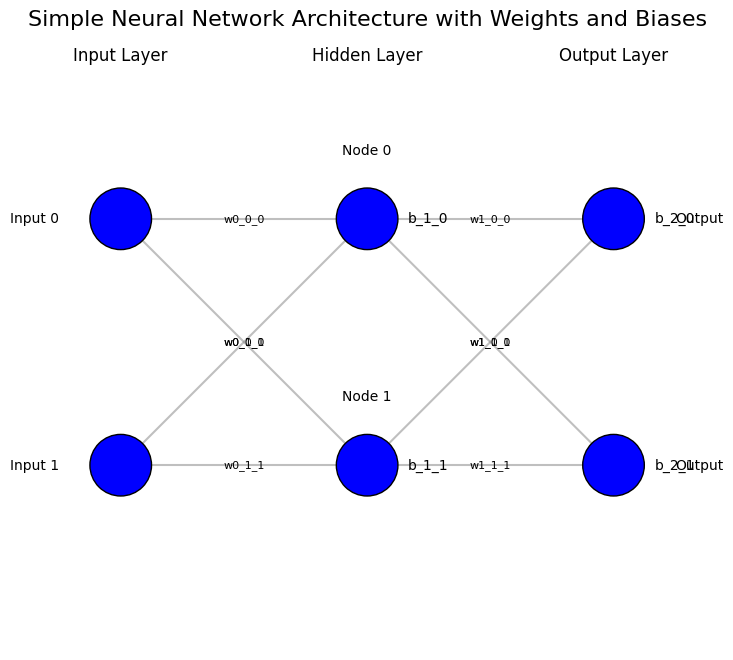

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def draw_neural_net_with_labels(ax, left, right, bottom, top, layer_sizes):
    '''
    Draws a neural network diagram with weight and bias labels.

    Parameters:
    - ax: Matplotlib axes object to draw on.
    - left, right, bottom, top: Coordinates for the drawing area.
    - layer_sizes: A list of integers, where each integer represents the number of nodes in a layer.
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(n_layers - 1)

    # Nodes
    for n in range(n_layers):
        layer_top = v_spacing * (layer_sizes [n] - 1) / 2.0 + (top + bottom) / 2.0
        for m in range(layer_sizes [n]):
            x = n * h_spacing + left
            y = layer_top - m * v_spacing
            circle = plt.Circle((x, y), v_spacing / 8.0, color='blue', ec='black', zorder=4)
            ax.add_artist(circle)

            # Add bias labels (only for hidden and output layers)
            if n > 0:
                ax.text(x + v_spacing / 6.0, y, f'b_{n}_{m}', va='center', ha='left')

            # Add node labels
            if n == 0:
                ax.text(x - v_spacing / 4.0, y, f'Input {m}', va='center', ha='right')
            elif n == n_layers - 1:
                ax.text(x + v_spacing / 4.0, y, f'Output', va='center', ha='left')
            else:
                ax.text(x, y + v_spacing / 4.0, f'Node {m}', va='bottom', ha='center')

    # Edges and weight labels
    weight_counter = 0
    for n in range(n_layers - 1):
        layer_top_n = v_spacing * (layer_sizes [n] - 1) / 2.0 + (top + bottom) / 2.0
        layer_top_n1 = v_spacing * (layer_sizes [n + 1] - 1) / 2.0 + (top + bottom) / 2.0
        for m in range(layer_sizes [n]):
            for o in range(layer_sizes [n + 1]):
                x1 = n * h_spacing + left
                y1 = layer_top_n - m * v_spacing
                x2 = (n + 1) * h_spacing + left
                y2 = layer_top_n1 - o * v_spacing
                line = plt.Line2D([x1, x2], [y1, y2], c='gray', alpha=0.5)
                ax.add_artist(line)

                # Add weight labels in the middle of the edges
                mid_x = (x1 + x2) / 2.0
                mid_y = (y1 + y2) / 2.0
                ax.text(mid_x, mid_y, f'w{n}_{m}_{o}', va='center', ha='center', fontsize=8)
                weight_counter += 1

# Define the architecture
layer_sizes = [2, 2, 2]

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
ax.set_aspect('equal')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

draw_neural_net_with_labels(ax, .1, .9, .1, .9, layer_sizes)

# Add titles for the layers
plt.text(0.1, 0.95, 'Input Layer', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
plt.text(0.5, 0.95, 'Hidden Layer', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
plt.text(0.9, 0.95, 'Output Layer', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)

plt.title('Simple Neural Network Architecture with Weights and Biases', fontsize=16)
plt.show()

#### Weights and Biases

- Call the input layer layer 0, the intermediate layer layer 1, and the output layer layer 2
- From top to bottom, let's number the nodes from 0 to $N$. $N$ is 2 in this case

- This is a basic visualisation of how weights and biases exist in a basic network. 
    - Weights exist between nodes on successive layers, and are denoted by "w<layer>\_<prev_layer_node_id>_<next_layer_node_id>". 
        - **For simplicity, let's shorten this to $w^{l-1,l}_{j,k}$**
        - $l$ is the layer ID, $j$ is the node index of the previous layer, and $k$ is the node index of the next layer
    - Biases exist on nodes, and are denoted by "b<layer>_<node_id>"
        - **For simplicity, let's shorten this to $b^{l}_{k}$**
        - $l$ is the layer ID, $k$ is the node index of the node where the bias is tagged to

#### Composing Outputs

- At every node (excluding the input node), the output from that node is defined to be the dot product of the weights and the outputs from the nodes of the previous layers, plus the node's bias

- That is;
$$\begin{aligned}
    a^{l}_{k} &= w^{l-1, l}_{j,k} \cdot a^{l-1}_{j} + b^{l}_{k} & \qquad (1)
\end{aligned}$$

#### Activation 

- We want to constrain the output i.e. $a^{l}_{k}$ is some way, because empirically it seems to help the network learn. The theoretical justification for this is because of the introduction of non-linearity

- There are many types of activations, and we will study them in detail in a subsequent section. For now, let's look at the simplest activation: **ReLU**

$$\begin{aligned}
    \text{ReLU}(a_k^l) &= \begin{cases}
        a^l_k       & \text{if } a^l_k \gt 0 \\
        0         & \text{if } a^l_k \leq 0
    \end{cases} & \qquad (2)
\end{aligned}$$

#### Final Layer Output

- The output of the final layer is no different from the output of any intermediate layer; it is composed by the combination of its associated weights and biases 

- In regression problems, the output of the final node is simply the raw output of your network. So no extra steps needed

- In classification type problems, an additional step is needed to ensure that the final layer outputs sum to 1, since classification requires probabilities as output

- This is known as **softmax**, which we will denote by $\sigma$
$$\begin{aligned}
    \sigma(x_i) &= \frac{e_{x_i}}{\sum_{j=0}^{n} e^{x_j}} & \qquad (3)
\end{aligned}$$


#### Loss Function

- Finally, we need a way to compute how wrong the network's output should be. This is known as the **loss function**

- There are many loss functions you can choose from, and it is important to have losses that correspond to exactly what you are trying to achieve. 

- In this case, let's use a common loss function: **cross entropy**

$$\begin{aligned}
    L &= - \sum_{i=0}^{N} y_i \log(\hat{y_i}) & \qquad (4)
\end{aligned}$$

### Step by Step: Backpropagation

- Using the network defined in the previous section, we know that the network's output should be an array of size 2. 

- Let's say our ground truth is $[0,1]$ , and the network's final output (i.e. after softmax) is $[0.5,0.5]$

#### Step 1: Compute loss $L$

$$\begin{aligned}
    L &= - \sum_{i=0}^{N} y_i \log(\hat{y}) \\
    &= -[(0 \log(0.5)) + (1 \log(0.5))] \\
    &\approx 0.693
\end{aligned}$$

- Remember, our objective here is to figure out the sensitivity of this loss value to the various weights in our

#### Step 2: Compute gradient of loss w.r.t final layer raw output